In [1]:
from string import punctuation, digits
from collections import Counter
from pprint import pprint
import os
import re

from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim.corpora as corpora
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.util import ngrams
import seaborn as sns
import pandas as pd
import numpy as np
import gensim
import nltk

In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-2])
DATA_PATH = f'{ROOT_PATH}/Dataset/metacritic'

In [3]:
df        = pd.read_csv(f'{DATA_PATH}/all_games.csv')
df_des    = pd.read_csv(f'{DATA_PATH}/games_of_all_time.csv')

In [4]:
with pd.ExcelWriter(f'{DATA_PATH}/dats.xlsx') as writer:
     
    df.to_excel(writer, sheet_name = 'all')
    df_des.to_excel(writer, sheet_name = 'description')

In [5]:
meta_df  = df.copy()
des_copy = df_des.copy()

meta_df['user_review'].replace(to_replace = 'tbd', value=np.nan, inplace = True)
meta_df = meta_df.astype({'user_review' : np.float16, 'meta_score' : np.int8})
meta_df['release_date'] = pd.to_datetime(meta_df['release_date'])
meta_df['year']         = meta_df.set_index('release_date').index.year

In [6]:
group = meta_df.groupby('name')
meta_transformed = group.agg({
                    'meta_score'  :   'mean',
                    'user_review' :   'mean',
                    'year'        :    'min',
                    'summary'     : 'unique',
                    'platform'    : 'unique'
                  })

meta_transformed = meta_transformed.reset_index()
meta_transformed

,name,meta_score,user_review,year,summary,platform
0,#DRIVE,69.0,NaN,2021,[#DRIVE is an endless driving videogame inspir...,[ Switch]
1,#IDARB,77.0,6.898438,2015,[#IDARB started as a picture of red box. Then ...,[ Xbox One]
2,#KILLALLZOMBIES,53.0,NaN,2016,[In the distant future; #KILLALLZOMBIES is thr...,[ Xbox]
3,'Splosion Man,84.0,7.800781,2009,"[[Xbox Live Arcade] Fools they were, to tread ...",[ Xbox 360]
4,.detuned,46.0,3.699219,2009,[[Playstation Network] Developed by .theproduk...,[ Xbox 360]
...,...,...,...,...,...,...
12249,rain,72.0,7.800781,2013,"[Developed by PlayStation C.A.M.P!, the creati...",[ PlayStation 3]
12250,theHunter: Call of the Wild,64.0,7.101562,2017,[Experience the thrill of the hunt in a vast o...,[ PC]
12251,uDraw Studio,71.0,NaN,2010,"[Packaged with the uDraw GameTablet, uDraw Stu...",[ Wii]
12252,void tRrLM(); //Void Terrarium,74.0,7.000000,2020,"[In a world contaminated with toxic fungi, a d...",[ Switch]


In [7]:
def evaluate(x):
    
    if type(x) == str: return eval(x)
    else: return np.nan


def boolean_df(item_lists, unique_items):
    
    bool_dict = {}
    for idx, item in enumerate(unique_items):
        
        bool_dict[item] = item_lists.apply(lambda x: item in x)
    
    return pd.DataFrame(bool_dict)


def transform(platform):
    
    for idx, text in enumerate(platform):
        
        text = text.strip(" -:,.;'")
        text = text.strip('"')
        text = text.lower()
        text = text.replace('-', '')
        text = text.replace('.', ' ')
        platform[idx] = text
        
    return platform


to_1D = lambda series: pd.Series([x for _list in series for x in _list])

In [8]:
des_copy['platform'] = des_copy['platform'].apply(eval)
des_copy['genre']    = des_copy['genre'].apply(evaluate)

In [9]:
df = des_copy.merge(meta_transformed, how = 'inner', 
                    left_on = 'game_name', right_on = 'name').drop(['name'], axis = 1)
df['platform_y'] = df['platform_y'].apply(transform)
df['platform_y'] = df['platform_y'].apply(list)
df['platform_x'] = df['platform_x'].apply(transform)
df['platform']   = (df['platform_x'] + df['platform_x']).apply(np.array).apply(lambda x: np.unique(x))

In [10]:
df['summary']     = df['summary'].apply(list)
df['description'] = list(np.expand_dims(df['description'].apply(np.array), axis = 1))

df['description'] = df['description'].apply(list)
df['plot']        = (df['summary'] + df['description']).apply(np.array).apply(lambda x: np.unique(x))

In [11]:
df['user_review'] = df['user_review'].round(1)
df.rename(columns = {'meta_score_x' : 'meta_score'})
df                = df.drop(['platform_x', 'platform_y', 'description', 'summary', 
                             'user_review', 'meta_score_y'], axis = 1)


In [12]:
lemmatizer = WordNetLemmatizer()
stop       = set(stopwords.words('english'))
stop       = ENGLISH_STOP_WORDS.union(stop)
game_word  = stop.union(['game','play','free','best','fun','new','enjoy','1',
                   'real','epic','challenge','app','make','mobile','win', 
                   'android','100','2020','2021','1000','version', 
                   'youtube','facebook','instagram','twitter','multiplayer','singleplayer'
                   "xbox","live","gameplay","experience","player","mode","feature","character",
                   "world","help","live","edition","episode","fantastic",
                   "action","adventure","shooter","roleplaying","miscellaneous","strategy","arcade",
                   "thirdperson","firstperson","3d","2d","sports","scifi","fantasy","racing","simulation",
                   "traditional","realtime","openworld","survival","music","horror",
                   'nintendo64', 'wii', 'gamecube', 'switch', 'xbox', 'dreamcast','playstation3',
                    'playstation', 'playstation2', 'pc','gameboyadvance', 'playstation4', '3ds', 'xbox360',
                    'wiiu','playstationvita', 'ds', 'xboxone', 'psp', 'playstation5','xboxseriesx', 'stadia'])

In [13]:
def remove_romano(text):
    
    roman2digit = {'i'  : 1, 'ii' : 2, 'iii' : 3, 'iv'   : 4,
                   'v'  : 5, 'vi' : 6, 'vii' : 7, 'viii' : 8,
                   'ix' : 9, 'x'  : 10}
    
    return [roman2digit[word] if word in roman2digit.keys() else word for word in text]


def remove_url(text):
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', 
                  '', text)
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", text).split())


def remove_email(text):
    
    return re.sub('\S*@\S*\s?', '', text)


def remove_brackets(text):
    
    text = re.sub(r'\[([A-Za-z0-9_]+)\]', '', text)
    text = re.sub(r'\{([A-Za-z0-9_]+)\}', '', text)
    text = re.sub(r'\(([A-Za-z0-9_]+)\)', '', text)
    
    return text


def decontraction(phrase):
    
    phrase = re.sub(r'n\'t, ',   ' not', phrase)
    phrase = re.sub(r'\'re'  ,   ' are', phrase)
    phrase = re.sub(r'\'s'   ,    ' is', phrase)
    phrase = re.sub(r'\'d'   , ' would', phrase)
    phrase = re.sub(r'\'ll'  ,  ' will', phrase)
    phrase = re.sub(r'\'t'   ,   ' not', phrase)
    phrase = re.sub(r'\'ve'  ,  ' have', phrase)
    phrase = re.sub(r'\'m'   ,    ' am', phrase)
    
    return phrase


def contraction(phrase):
    
    phrase = re.sub( r'single player',  'singleplayer', phrase)
    phrase = re.sub(  r'multi player',   'multiplayer', phrase)
    phrase = re.sub(r'electronic art', 'electronicart', phrase)
    phrase = re.sub(    r'open world',     'openworld', phrase)
    phrase = re.sub(  r'role playing',   'roleplaying', phrase)
    phrase = re.sub(     r'world war',      'worldwar', phrase)
    
    return phrase


def remove_stopwords(text):
    
    return [word for word in word_tokenize(text) if word.lower() not in stop]


def lemmatization(text):
    
    return [lemmatizer.lemmatize(word.lower(), pos = 'n') for word in text]


def remove_gamewords(text):
    
    return [word for word in text if word not in game_word]


def remove_digits(text):
    return [word for word in text if not str(word).isdigit()]


def keep_alpha(text):
    
    return [word for word in text if str(word).isalpha()]


def remove_escape_sequences(text):
    
    text = text.replace('\n', '')
    text = text.replace('\t', '')
    text = text.replace('\r', '')
    
    return text

In [14]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('wordnet2022')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
def cor(x):
    
    l = []
    for idx in x:
        
        try:
            idx = remove_escape_sequences(idx.strip().lower())
            idx = remove_url(idx)
            idx = remove_email(idx)
            l.append(idx)
            
        except: pass
        
    s = ''
    for j in np.unique(np.array(l)):
        s = s + " " + j
        
    return s

In [16]:
df['description'] = df['plot'].apply(cor)
df.loc[df['description'].str.lower().str.contains('multiplayer'),  'type'] = 'multiplayer'
df.loc[df['description'].str.lower().str.contains('multi-player'), 'type'] = 'multiplayer'
df['type'].fillna('singleplayer', inplace = True)

In [17]:
df.rating.value_counts()

rating
T       2619
E       2353
M       1530
E10+    1123
RP        14
K-A        6
AO         1
Name: count, dtype: int64

In [18]:
df.loc[[1947, 2393, 3135, 6925, 7326, 8448], 'developer'] = ['FireFly Studios', 'Sledgehammer Games', 
                                                             'Farsight Studios', 'Red Barrels', 'HB Studios Multimedia',
                                                             'French-Bread']
df.developer.fillna('other', inplace = True)

In [19]:
df.loc[df['rating'].isin(['RP', 'K-A', 'AO', np.nan]), 'rating'] = 'T'
df.loc[1099, 'genre'] = [['Action']]
df.loc[3135, 'genre'] = [['Action']]
df.loc[5401, 'genre'] = [['Action']]
df.loc[8448, 'genre'] = [['Action']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8776 entries, 0 to 8775
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   game_name     8776 non-null   object 
 1   meta_score_x  8776 non-null   float64
 2   user_score    8776 non-null   float64
 3   url           8776 non-null   object 
 4   developer     8776 non-null   object 
 5   genre         8776 non-null   object 
 6   type          8776 non-null   object 
 7   rating        8776 non-null   object 
 8   year          8776 non-null   int32  
 9   platform      8776 non-null   object 
 10  plot          8776 non-null   object 
 11  description   8776 non-null   object 
dtypes: float64(2), int32(1), object(9)
memory usage: 788.6+ KB


In [20]:
df_preprocessed = df.copy()
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8776 entries, 0 to 8775
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   game_name     8776 non-null   object 
 1   meta_score_x  8776 non-null   float64
 2   user_score    8776 non-null   float64
 3   url           8776 non-null   object 
 4   developer     8776 non-null   object 
 5   genre         8776 non-null   object 
 6   type          8776 non-null   object 
 7   rating        8776 non-null   object 
 8   year          8776 non-null   int32  
 9   platform      8776 non-null   object 
 10  plot          8776 non-null   object 
 11  description   8776 non-null   object 
dtypes: float64(2), int32(1), object(9)
memory usage: 788.6+ KB


In [21]:
def expand(idx):
    
    if 'Action Adventure' in idx:
        
        if 'Action' not in idx:
            idx.append('Action')
            
        if 'Adventure' not in idx:
            idx.append('Adventure')
            
        idx.remove('Action Adventure')
        
    return idx

In [22]:
s               = to_1D(df.genre.apply(expand)).value_counts()
l               = list(s[s > 500].index) + ['Real-Time', 'Open-World', 'Survival', 
                                            'Horror', 'Third-Person']
genres          = df.genre
bool_df         = boolean_df(genres.apply(expand), to_1D(genres.apply(expand)).unique())

df_preprocessed = pd.concat([df_preprocessed, bool_df], axis = 1)
df_preprocessed.drop(['genre'], axis = 1, inplace = True)

In [23]:
d={'nintendo':['nintendo64','gamecube','dreamcast','game-boy-advance','3ds','ds'],
 'wii':['wii','wiiu'],
 'switch':['switch'],
 'xbox':['xbox','xbox360','xboxone','xboxseriesx','stadia'],
 'playstation':['playstation3', 'playstation', 'playstation2','playstation4','playstationvita','playstation5'],
 'pc':['pc'],
 'psp':['psp']
}

def check(x,d):
    for i in x:
        if i in d:
            return True
    return False

def oheplatform(s,d):
    bool_dict = {}
    for k in d.keys():
        bool_dict[k]= s.apply(lambda x: check(x,d[k]))
    return pd.DataFrame(bool_dict)

In [24]:
df_preprocessed = pd.concat([df_preprocessed,oheplatform(df['platform'],d)],axis=1)
df_preprocessed.drop(['platform'],axis=1,inplace=True)

In [25]:
def transform_dev(text):
    
    text = text.strip().lower()
    text = decontraction(text)
    text = remove_stopwords(text)
    text = lemmatization(text)
    text = remove_gamewords(text)
    text = keep_alpha(text)
    
    return text


s  = df['developer'].apply(transform_dev)
s0 = to_1D(s).value_counts()
s0[s0 > 40]

studio           926
entertainment    492
software         339
interactive      278
ea               239
ubisoft          195
capcom           156
nintendo         132
digital          125
namco            110
sport            105
telltale         104
production        98
team              95
konami            91
bandai            79
square            77
enix              75
montreal          74
corporation       69
sega              68
art               65
canada            63
development       53
force             52
omega             52
level             51
black             47
work              47
red               45
electronic        44
lab               44
Name: count, dtype: int64

In [26]:
def tokenize(str_, count, list_):
    
    dev = []
    for val in str_:
        max_ = 0
        freq = np.nan
        
        for idx in val:
            
            if idx in count.index and idx not in list_ and count[idx] > max_:
                max_ = count[idx]
                freq = idx
                
        if max_ <= 5: dev.append(np.nan)
        else: dev.append(freq)
        
    return pd.Series(dev)


l  = ['game','studio','entertainment','software','interactive','digital','sport','production','corporation','development','art','team','work']
s1 = tokenize(s,to_1D(s).value_counts(),l)
s1.value_counts()[(s1.value_counts()>30)]

ea             239
ubisoft        195
capcom         156
nintendo       132
namco          110
telltale       104
konami          91
square          76
sega            68
omega           52
level           51
red             45
electronic      44
lab             41
black           40
codemasters     38
ninja           38
arc             38
llc             38
medium          37
atlus           37
vision          37
nippon          36
visual          36
milestone       34
maxi            34
midway          34
blue            33
koei            33
double          33
high            33
blizzard        32
rockstar        32
creative        32
sony            31
reality         31
tale            31
Name: count, dtype: int64

In [27]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8776 entries, 0 to 8775
Columns: 184 entries, game_name to psp
dtypes: bool(174), float64(2), int32(1), object(7)
memory usage: 2.1+ MB


In [28]:
dummy           = pd.get_dummies(s1)[s1.value_counts()[s1.value_counts() > 30].index]
df_preprocessed = pd.concat([df_preprocessed, dummy], axis = 1)
df_preprocessed.drop(['developer'], axis = 1, inplace = True)

df_preprocessed = pd.get_dummies(data       = df_preprocessed, columns = ['type', 'rating'],
                                 drop_first = True)

In [29]:
df_preprocessed[['meta_score_x', 'user_score']] = df_preprocessed[['meta_score_x', 'user_score']] / 100
numerator               = (df_preprocessed['year'] - df_preprocessed['year'].min())
denominator             = (df_preprocessed['year'].max() - df_preprocessed['year'].min())
df_preprocessed['year'] = numerator / denominator

<Axes: xlabel='user_score', ylabel='meta_score_x'>

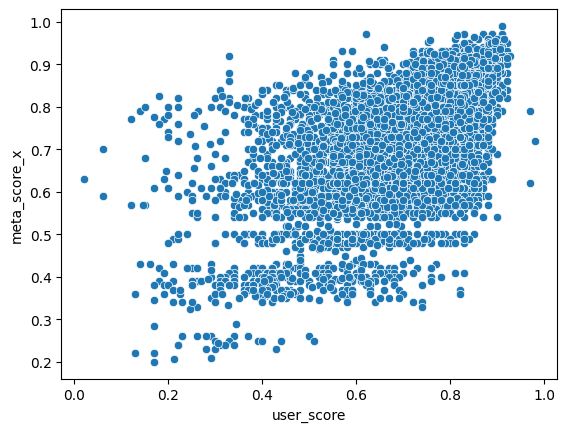

In [30]:
sns.scatterplot(data = df_preprocessed, x = 'user_score', y = 'meta_score_x')

In [31]:
df_preprocessed = df_preprocessed[(df_preprocessed['meta_score_x'] > 0.5) | df_preprocessed['user_score'] > 0.35]
df_preprocessed = df_preprocessed.reset_index().drop(['index'], axis = 1)

description     = df_preprocessed['description'].values.tolist()

In [32]:
def transform_des(text):
    
    text = text.strip().lower()
    text = remove_url(text)
    text = remove_email(text)
    text = decontraction(text)
    text = remove_stopwords(text)
    text = lemmatization(text)
    text = remove_romano(text)
    text = remove_gamewords(text)
    text = remove_digits(text)
    text = keep_alpha(text)
    
    return text


def proper_name(name):
    
    name = name.strip(" ',-;").lower()
    name = decontraction(name)
    name = name.split(":")[0]
    name = remove_brackets(name)
    name = lemmatization(remove_stopwords(name))
    name = remove_romano(name)
    name = remove_gamewords(name)
    name = keep_alpha(name)
    
    text = ''
    for s in name: text += f'{s} '
    
    return text.strip()

In [33]:
game_corpus = [proper_name(idx) for idx in df_preprocessed.game_name.values]
game_text   = [' '.join(d) for d in game_corpus]
temp        = Counter(game_corpus).most_common()
gameword    = pd.DataFrame(temp, columns = ['Word', 'Count'])
gameword

,Word,Count
0,,202
1,duty,38
2,nba,36
3,sims,35
4,walking dead,30
...,...,...
5678,htol niq,1
5679,nail,1
5680,ooo,1
5681,udraw studio,1


In [34]:
name   = [idx.strip().split(':')[0] for idx in df_preprocessed['game_name'].values]
series = pd.Series(name).value_counts()
game_names=['Mortal Kombat', 'Guitar Hero', 'Halo', 'Need for Speed', 'Madden NFL',
       'Pro Evolution Soccer', 'Donkey Kong', 'Sonic', 'Resident Evil',
       'Grand Theft Auto', 'Final Fantasy', 'Warcraft', 'FIFA',
       'Street Fighter', 'Dragon Quest', 'Wii', 'Pac-Man', 'Call of Duty',
       'Dragon Ball', 'Mario', 'Star Wars', 'Pokemon','Tetris','Minecraft','Sims','NHL',"Assassin's Creed",'The Legend of Zelda','NBA','Star Wars','Tomb Raider','Battlefield'
       ,'Metal Gear','Tekken','God of War','Uncharted','The Walking Dead','Batman','MLB','Warhammer','Dynasty Warrior','Naruto','Transformers','MotoGP']

In [35]:
count = []
for name in game_names: count.append((df.game_name.str.contains(name)).sum())

popular_frenchise = pd.Series(count, index = game_names)
popular_frenchise.sort_values()

God of War               8
Uncharted                9
Tekken                  11
Grand Theft Auto        11
Minecraft               12
Tetris                  12
Mortal Kombat           13
Guitar Hero             13
Pro Evolution Soccer    13
Donkey Kong             13
Tomb Raider             13
Wii                     14
MotoGP                  14
Halo                    15
Transformers            15
Metal Gear              16
Dragon Quest            17
Warcraft                17
Pac-Man                 18
Street Fighter          19
The Legend of Zelda     21
Warhammer               22
Battlefield             23
Madden NFL              24
Dynasty Warrior         24
Dragon Ball             25
Need for Speed          25
Naruto                  27
MLB                     28
Batman                  29
The Walking Dead        32
Assassin's Creed        34
Resident Evil           35
FIFA                    37
Pokemon                 39
Call of Duty            39
NHL                     40
S

In [36]:
def generate_ngrams(text, n):
    
    words = word_tokenize(text)
    return [' '.join(ngram) for ngram in list(get_data(ngrams(words, n))) 
            if not all(w in stop for w in ngram)]


def get_data(gen):
    
    try:
        for elem in gen: yield elem
        
    except (RuntimeError, StopIteration):
        return

In [37]:
description_words = [transform_des(des) for des in description]
description_text  = [' '.join(des) for des in description_words]

corpus      = []
tmp         = Counter(corpus).most_common()
commonwords = pd.DataFrame(tmp, columns = ['Word', 'Count'])

df_preprocessed.drop(['plot', 'description'], axis = 1, inplace = True)

In [38]:
tvec         = TfidfVectorizer(min_df = .03, max_df = .1, stop_words = 'english', ngram_range = (1, 1))
tvec_weights = tvec.fit_transform(description_text)

weights      = np.asarray(tvec_weights.mean(axis = 0)).ravel().tolist()
weights_df   = pd.DataFrame({'term' : tvec.get_feature_names_out(), 'weight' : weights})

selected_weights = weights_df.sort_values(by = 'weight', ascending = False)
selected_weights = selected_weights[selected_weights['weight'] >= 0.012]

selected_weights

,term,weight
191,war,0.029979
25,city,0.028013
140,puzzle,0.026987
115,mission,0.026416
124,online,0.026270
...,...,...
33,coop,0.012106
53,element,0.012082
67,favorite,0.012057
173,test,0.012011


In [39]:
selected_mat = tvec_weights.toarray()[:, selected_weights.index.tolist()]
selected_mat.shape

(8776, 104)

In [40]:
tfidf_df = pd.DataFrame(selected_mat, columns = selected_weights.term.tolist())
tfidf_df.head()

,war,city,puzzle,mission,online,classic,hero,race,original,like,...,earth,speed,defeat,solve,turn,coop,element,favorite,test,includes
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.127878,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.262768,0.0,0.260534,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.309103
3,0.0,0.0,0.303763,0.284489,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.355386,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [41]:
id2word = corpora.Dictionary(description_words)
texts   = description_words
corpus  = [id2word.doc2bow(text) for text in texts]
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 3), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1)]


In [42]:
def compute_coherence_values(dict_, corpus, texts, limit, start = 2, step = 3):

    model_list       = []
    coherence_values = []
    
    for num_topics in range(start, limit, step):
        
        print(f'idx : {num_topics} / {limit}')
        model = gensim.models.ldamodel.LdaModel(
                                                corpus  =  corpus,   num_topics = num_topics,
                                                id2word = id2word, random_state =         99,
                                                update_every = 1, chunksize = 100, passes = 10,
                                                alpha = 'auto', per_word_topics = True
                                              )
        model_list.append(model)
        coherencemodel = CoherenceModel(model      = model, texts = texts, 
                                        dictionary = dict_,
                                        coherence  = 'c_v')

        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

idx : 2 / 10
idx : 3 / 10
idx : 4 / 10
idx : 5 / 10
idx : 6 / 10
idx : 7 / 10
idx : 8 / 10
idx : 9 / 10


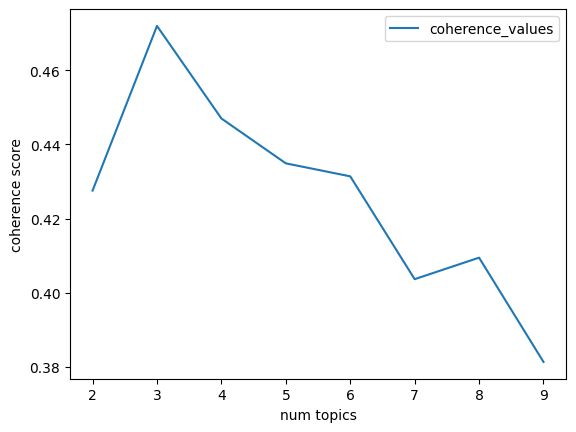

In [43]:
start, limit, step = 2, 10, 1
model_list, coherence_values = compute_coherence_values(id2word, corpus, description_words,
                                                        limit, start, step)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('num topics')
plt.ylabel('coherence score')
plt.legend((['coherence_values']), loc = 'best')
plt.show()

In [44]:
num_topics = 5
lda_model  = gensim.models.ldamodel.LdaModel(corpus          =     corpus,
                                             id2word         =    id2word,
                                             num_topics      = num_topics,
                                             random_state    =         99,
                                             update_every    =          1, 
                                             chunksize       =        100,
                                             passes          =         10,
                                             alpha           =     'auto',
                                             per_word_topics =       True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]                   

[(0,
  '0.011*"power" + 0.011*"story" + 0.008*"time" + 0.008*"hero" + '
  '0.008*"explore" + 0.007*"evil" + 0.007*"life" + 0.006*"set" + '
  '0.006*"journey" + 0.006*"fighter"'),
 (1,
  '0.016*"city" + 0.006*"mysterious" + 0.006*"man" + 0.006*"year" + '
  '0.006*"human" + 0.005*"set" + 0.005*"past" + 0.005*"order" + '
  '0.005*"mystery" + 0.005*"alien"'),
 (2,
  '0.016*"friend" + 0.016*"puzzle" + 0.014*"level" + 0.009*"way" + '
  '0.009*"super" + 0.007*"nintendo" + 0.007*"classic" + 0.007*"like" + '
  '0.006*"tour" + 0.005*"time"'),
 (3,
  '0.014*"battle" + 0.011*"weapon" + 0.010*"control" + 0.009*"mission" + '
  '0.008*"combat" + 0.008*"enemy" + 0.008*"team" + 0.008*"series" + '
  '0.007*"online" + 0.007*"including"'),
 (4,
  '0.012*"race" + 0.011*"street" + 0.008*"including" + 0.008*"team" + '
  '0.008*"track" + 0.008*"car" + 0.007*"sims" + 0.007*"compete" + '
  '0.006*"speed" + 0.006*"sport"')]


In [45]:
coherence_model_lda = CoherenceModel(model = lda_model, texts = description_words,
                                     dictionary = id2word, coherence = 'c_v')
coherence_lda       = coherence_model_lda.get_coherence()
print(f'Coherence Score : {coherence_lda:.2f}')

Coherence Score : 0.43


In [46]:
topic_features = np.zeros((len(corpus), num_topics))
for row, d in enumerate(corpus):
    
    topic_weights = lda_model.get_document_topics(d, minimum_probability = None)
    
    for t in topic_weights:
        topic_features[row, t[0]] = t[1]
        
topic_features = pd.DataFrame(topic_features, columns = [f'topic{idx}' for idx in range(num_topics)])
topic_features.head()

,topic0,topic1,topic2,topic3,topic4
0,0.552493,0.085411,0.193555,0.138928,0.029612
1,0.221220,0.128791,0.453879,0.165232,0.030879
2,0.179706,0.037539,0.515863,0.243895,0.022997
3,0.107913,0.545708,0.156177,0.170049,0.020152
4,0.371261,0.072065,0.397877,0.120573,0.038224


In [47]:
df_preprocessed = pd.concat([df_preprocessed, topic_features], axis = 1)
df_preprocessed = pd.concat([df_preprocessed, tfidf_df]      , axis = 1)

In [48]:
name = df_preprocessed[['game_name', 'url']]
df_preprocessed.drop(['game_name', 'url'], axis = 1, inplace = True)
cosine_sim = cosine_similarity(df_preprocessed, df_preprocessed)

In [49]:
def recommendation(str_):
    
    game_idx = name[name['game_name'] == str_].index[0]
    index    = cosine_sim[game_idx].argsort()[-2:-7:-1]
    return name.loc[index]

In [50]:
recommendation('Red Dead Redemption 2')

,game_name,url
5795,Grand Theft Auto V,https://www.metacritic.com/game/xbox-one/grand...
5794,Grand Theft Auto IV,https://www.metacritic.com/game/playstation-3/...
6526,Middle-earth: Shadow of War,https://www.metacritic.com/game/xbox-one/middl...
6501,Metal Gear Solid V: The Phantom Pain,https://www.metacritic.com/game/xbox-one/metal...
8595,Watch Dogs: Legion,https://www.metacritic.com/game/xbox-one/watch...
